In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix

In [2]:
train = pd.read_csv('train.csv')
train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,label
0,0,0.053680,0.021716,0.038365,0.018978,0.050558,0.014487,0.045645,0.024229,0.048973,...,0.001566,0.004200,0.003694,0.000292,0.003339,0.001020,0.002229,0.016256,0.025035,tensor([28])
1,1,0.021406,0.009394,0.019303,0.015335,0.019127,0.014633,0.023476,0.011325,0.012859,...,0.009081,0.025631,0.024931,0.004471,0.024436,0.029047,0.023606,0.028000,0.037590,tensor([23])
2,2,0.115857,0.084943,0.114644,0.093135,0.122910,0.093698,0.117069,0.075236,0.093919,...,0.075077,0.099196,0.101704,0.090110,0.098861,0.094983,0.082206,0.092425,0.092932,tensor([21])
3,3,0.092928,0.051591,0.086338,0.086184,0.103702,0.069361,0.084398,0.062472,0.091986,...,0.053972,0.068832,0.099421,0.070727,0.071631,0.074135,0.081881,0.080839,0.035885,tensor([24])
4,4,0.038478,0.010042,0.029132,0.033505,0.033954,0.027581,0.038581,0.024783,0.026107,...,0.049384,0.054094,0.071051,0.051793,0.062743,0.064802,0.057165,0.076673,0.046724,tensor([28])


In [3]:
val = pd.read_csv('val.csv')
test = val.tail(len(val) // 2)
test.reset_index(inplace=True)
val = val.head(len(val) // 2)

In [4]:
y_train = [int(train['label'][i][8:-2]) for i in range(len(train['label']))]
y_test = [int(test['label'][i][8:-2]) for i in range(len(test['label']))]
y_val = [int(val['label'][i][8:-2]) for i in range(len(val['label']))]
# У меня был неправильно сохранённый файл csv, в правильном случае используйте следующие строки
# y_train = train['label']
# y_test = test['label']
# y_val = val['label']

In [5]:
columns = train.columns[1:]
X_train = train[columns[:-1]]
X_test = test[columns[:-1]]
X_val = val[columns[:-1]]

### Объединим часть объектов

In [6]:
def replace_1300(y):
    for i in range(len(y)):
        y[i] = max(y[i], 16)
        
replace_1300(y_test)
replace_1300(y_train)
replace_1300(y_val)

### Отбор признаков
Без него работает лучше.

In [129]:
from sklearn.ensemble import RandomForestClassifier

rf_features = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=20,
                                     criterion='gini', verbose=1, n_jobs=-1)
rf_features.fit(X_train, y_train)
rf_predict = rf_features.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.9s finished


RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=500,
                       n_jobs=-1, verbose=1)

In [174]:
importance = rf_features.feature_importances_
all_features = columns
importance, all_features = zip(*sorted(zip(importance, all_features)))
rf_train = X_train[:][list(all_features[-5000:])]
rf_val = X_val[:][list(all_features[-5000:])]

### Обучение

In [8]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

In [9]:
sgd = SGDClassifier(n_jobs=-1, verbose=0)
sgd.fit(X_train, y_train

0.388951160928743
7.325700560448358


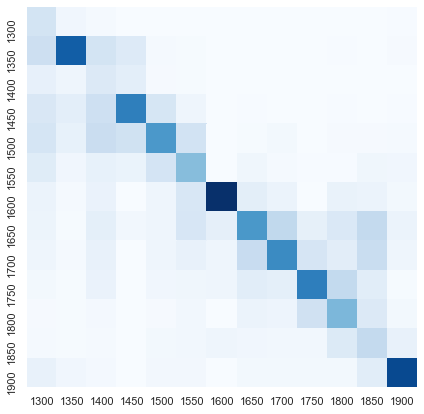

In [19]:
sgd_predict = sgd.predict(X_val)
print(f1_score(y_val, sgd_predict, average='micro'), mean_squared_error(y_val, sgd_predict), sep='\n')
cmat = confusion_matrix(y_val, sgd_predict)
plt.figure(figsize=(7,7))
sns.heatmap(cmat/np.sum(cmat, axis=0), annot=False, cbar=False,
            xticklabels=[1300 + i*50 for i in range(13)], yticklabels=[1300 + i*50 for i in range(13)], cmap='Blues') 
plt.show()

In [22]:
linear_svc = LinearSVC(verbose=2, max_iter=1000)
linear_svc.fit(X_train, y_train)

[LibLinear]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(verbose=2)

In [25]:
svc_predict = linear_svc.predict(X_test)

0.5082465972778223
4.035548438751001


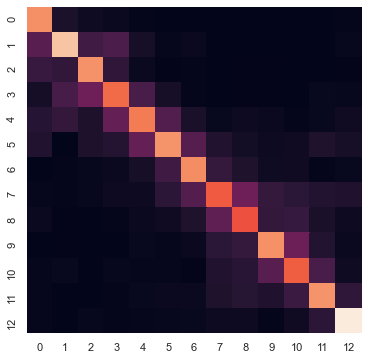

In [26]:
print(f1_score(y_test, svc_predict, average='micro'), mean_squared_error(y_test, svc_predict), sep='\n')
cmat = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat, axis=0), annot=False, cbar=False)
plt.show()

In [29]:
import joblib
joblib.dump(linear_svc, 'linear_svc.pkl')

['linear_svc.pkl']

In [ ]:
linear_svc_balanced = LinearSVC(verbose=2, class_weight='balanced')
linear_svc_balanced.fit(X_train, y_train)

[LibLinear]

In [ ]:
linear_svc_balanced_predict =

In [ ]:
print(f1_score(y_test, svc_predict, average='micro'), mean_squared_error(y_test, svc_predict), sep='\n')
cmat = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(7,7))
sns.heatmap(cmat/np.sum(cmat, axis=0), annot=False, cbar=False,
            xticklabels=[1300 + i*50 for i in range(13)], yticklabels=[1300 + i*50 for i in range(13)], cmap='Blues')
plt.show()

### Оценка

0.39295436349079266
7.351801441152922


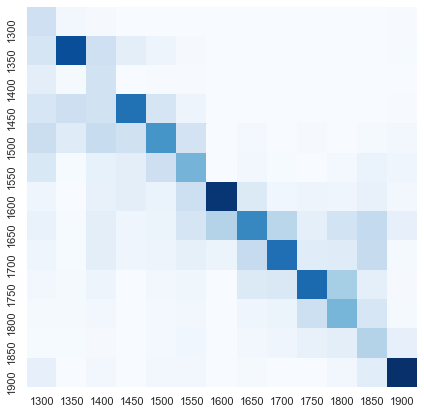

In [21]:
sgd_predict = sgd.predict(X_test)
print(f1_score(y_test, sgd_predict, average='micro'), mean_squared_error(y_test, sgd_predict), sep='\n')
cmat = confusion_matrix(y_test, sgd_predict)
plt.figure(figsize=(7,7))
sns.heatmap(cmat/np.sum(cmat, axis=0), annot=False, cbar=False,
            xticklabels=[1300 + i*50 for i in range(13)], yticklabels=[1300 + i*50 for i in range(13)], cmap='Blues')
plt.show()